## <center>Wages Prediction Modelling For The USA Computer Technology Occupations</center>

### Abstract
This paper investigates wage prediction models for computer technology occupations in the United States, employing a diverse set of predictors including age, gender, number of children in the household, employment class, education level, marital status, and citizenship status. The primary objective is to compare the performance between different models, from simple to complex, in predicting hourly wages for professionals in this sector. Four distinct models are considered, progressively incorporating additional predictors: a quadratic age model, a model adding gender and number of children, a model further incorporating employment class and education level and a model further accounting for marital and citizenship status. Through comparative analysis, I assess the predictive results of these models, seeking to identify the most effective model for wage estimation in computer technology occupations.

-----

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
%matplotlib inline

In [3]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

from stargazer import stargazer

### 1. Data

#### Data Preparation
The data in the paper is from the cps-earnings dataset at https://osf.io/g8p9j/. I then applied some filtering and transformations to end up with the working dataset. The filtering and transformations are as follows:
1. Get the raw dataset (N = 149,316)
2. Apply filters (N = 4,304):
    - Computer tech occupation codes from 1005 to 1107
    - Employee with a high school diploma and above 
    - Minimum 20 working hours per week 
    - Hourly wages of more than $1/hr
3. Transform some columns (N = 4,304):
    - Get hourly wages by dividing weekly wages by the number of working hours
    - Create a boolean variable for gender
    - Transform citizenship status text to numerical values
    - Transform employment class (public, private, self-employed,...) text to numerical values
    - Create dummy variables for citizenship status, employment class, marital status and education level
    - Add the square of age for non-linear regression

The models in this paper use hourly wages as the target variable. Other variables are used as predictors including:
- Age
- Square of Age
- Gender
- Number of children in the household
- Employment class
- Education level
- Marital status
- Citizenship status

In [4]:
# dictionary for citizenship status
citizenship_dict = {
    "Native, Born In US": 1,
    "Foreign Born, Not a US Citizen": 2,
    "Foreign Born, US Cit By Naturalization": 3,
    "Native, Born Abroad Of US Parent(s)": 4,
    "Native, Born in PR or US Outlying Area": 5
}

# dictionary for employment class
class_dict = {
    "Private, For Profit": 1,
    "Private, Nonprofit": 2,
    "Government - Federal": 3,
    "Government - State": 4,
    "Government - Local": 5
}

def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for: 
    #   occ2012 between 1005 and 1107 (Tech occupations), 
    #   high school graduate and above,
    #   work week > 0, 
    #   work minimum 20hrs per week, 
    #   hourly wages >= 1
    comp_sample = df[(df['occ2012'] >= 1005)
                     & (df['occ2012'] <= 1107)
                     & (df['grade92'] >= 39) 
                     & (df['uhours'] >= 20) 
                     & (df['earnwke'] > 0)
                     & (df['earnwke']/df['uhours'] >= 1)].iloc[:, 1:]
    
    #drop the raw df
    del df
    
    # Add a column 'hourly_wage' to the DataFrame
    comp_sample['hourly_wage'] = (comp_sample['earnwke'] / comp_sample['uhours']).round(decimals=2)
    # add column female to have boolean for male or female
    comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
    # add column for age squared
    comp_sample['agesq'] = np.power(comp_sample['age'], 2)
    # add column for citizen to have boolean value if worker has US citizenship
    comp_sample['citizenship_status_code'] = comp_sample['prcitshp'].apply(lambda x: citizenship_dict[x])
    # add column for occupation class code
    comp_sample['class_code'] = comp_sample['class'].apply(lambda x: class_dict[x])
    
    # create dummy variables
    comp_sample = pd.get_dummies(columns=['citizenship_status_code', 'marital', 'grade92', 'class_code'], data=comp_sample, prefix=['citizen', 'marital', 'edu', 'class'], drop_first=True, dtype=int)
    
    # round to 2 decimal places
    comp_sample = comp_sample.round(decimals=2)
    
    return comp_sample

In [5]:
cleaned_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment1/morg-2014-emp.csv')
#cleaned_df = get_cleaned_data('morg-2014-emp.csv')
cleaned_df.shape;

<p style="page-break-after:always;"></p>

#### Data Exploration

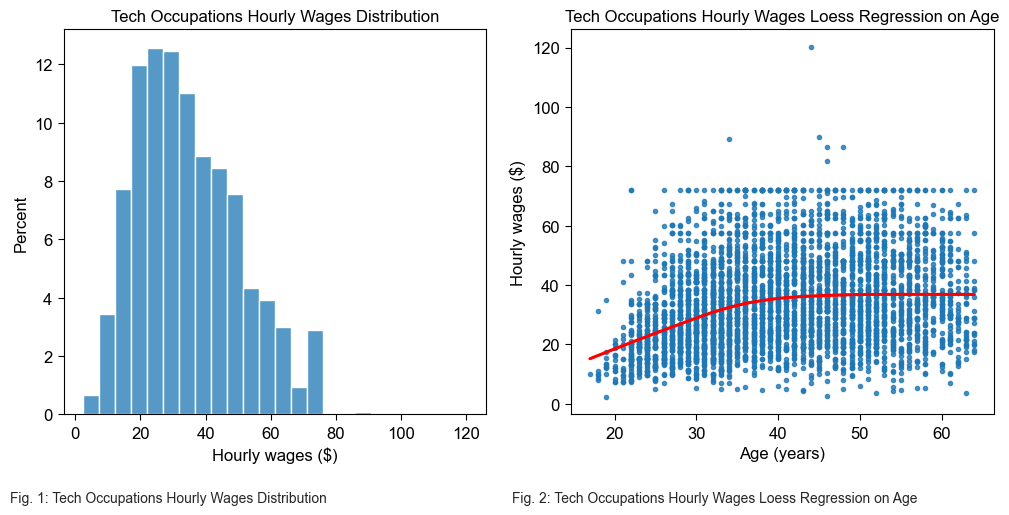

In [6]:
# figures for wages distribution and loess regression
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,5))
sns.set(style="white")
fig1 = (sns.histplot(
    data = cleaned_df,
    x = 'hourly_wage', stat='percent', binwidth=5, ax=ax1))
fig1.set(title='Tech Occupations Hourly Wages Distribution', xlabel="Hourly wages ($)", ylabel="Percent")
ax1.text(-20, -3, 'Fig. 1: Tech Occupations Hourly Wages Distribution', size=10)
fig2 = (sns.regplot(
    data = cleaned_df,
    x = 'age', y = 'hourly_wage', 
    marker= '.',
    fit_reg= True, lowess= True, line_kws={"color": "red"}, ax=ax2))
fig2.set(title='Tech Occupations Hourly Wages Loess Regression on Age', xlabel='Age (years)', ylabel='Hourly wages ($)')
ax2.text(7.5, -33, 'Fig. 2: Tech Occupations Hourly Wages Loess Regression on Age', size=10)
fig.show()

From Fig. 1, it is clear that the target variable hourly wages is left-skewed. This means that the mean value of hourly wages is not the typical value. Within this paper, the models will assume that the mean is typical and will predict the mean value. It is worth noting that normally this is not the case and there might be impacts on the prediction results made by the models.

In Fig. 2, I construct the loess regression of hourly wages on age as the primary independent variable. The loess line shows a positive trend from age 15 to 35, then gradually flatten from 35 onward. There is a non-linear relationship between hourly wages and age. Thus, a square term is included in the subsequent model used for hourly wage prediction to represent this non-linearity.

---

### 2. Models
For this paper, I constructed four predictive models, from simple to complex, to try to predict the hourly wages for a professional in the computer technology sector. Each model is a linear regression with the OLS method, where the target variable is hourly wages and the predictors as listed in the **Data** section above. 

**Model 1 - Hourly wages on age and square of age**

$Hourly\ wages = \beta_0 + \beta_1\times age + \beta_2\times age^2 + \epsilon$

Model 1 only uses age and the square of age as predictors for hourly wages. From intuition, employees of higher age usually have more experience and expertise than younger employees. Hence, age often correlates with professional experience and expertise, which can influence wages. The inclusion of age squared allows for capturing potential non-linear relationships, acknowledging that the impact of age on wages is non-linear as in the loess regression above.

**Model 2 - Extension of model 1 with gender and number of children**

$Hourly\ wages = \beta_0 + \beta_1\times age + \beta_2\times age^2 + \beta_3\times isFemale + \beta_4\times numberChildren + \epsilon$

Model 2 extends with the inclusion of gender and the number of children in the household as predictors. Gender has often been a focal point in discussions to pay equity. By incorporating gender as a predictor, model 2 aims to cover the wage disparities between male and female professionals. Additionally, the inclusion of the number of children variable represents any potential differences in hourly wages for professionals with children. Employees having more children might demand more wages to fulfill their responsibilities raising their offspring.

**Model 3 - Extension of model 2 with employment class and education level**

$Hourly\ wages = \beta_0 + \beta_1\times age + \beta_2\times age^2 $
$+ \beta_3\times isFemale + \beta_4\times numberChildren $
$+ \beta_i\times C(employmentClass) + \beta_k\times C(educationLevel) + \epsilon$

Model 3 extends from model 2 with employment class and education level variables. Professionals who are employed in the public sector might receive different wages than those working in the private sector or self-employed. Furthermore, it is intuitive that professionals with higher education levels like a Master's degree or PhD degree might receive higher wages with their advanced knowledge or training. The inclusion of these variables acknowledges the potential variation in wages with the employment class and level of education.

**Model 4 - Extension of model 3 with marital status and citizenship status**

$Hourly\ wages = \beta_0 + \beta_1\times age + \beta_2\times age^2 $
$+ \beta_3\times isFemale + \beta_4\times numberChildren $
$+ \beta_i\times C(employmentClass) + \beta_k\times C(educationLevel) $ 
$+ \beta_j\times C(maritalStatus) + \beta_l\times C(citizenshipStatus) + \epsilon$

Finally, model 4 further extends from model 3 with the inclusion of citizenship status and marital status variables. The USA attracts a large number of immigrant professionals to join the US workforce. Hence, the addition of the citizenship status in this model is necessary to represent the potential wage gap among immigration statuses. With martial status, professionals with different family obligations might have some relationship with their received hourly wage. Model 4 includes marital status variables to suggest this variation in hourly wage.

In [7]:
### Cross validate OLS with combining sklearn k-fold cross validation and statsmodels ols formula
def cv_reg(formula, data, kfold, robustse=None):
    regression_list = []
    predicts_on_test = []
    rsquared = []
    rmse_list = []
    rmse_list_test = []

    # Calculating OLS for each fold

    for train_index, test_index in kfold.split(data):
        # print("TRAIN:", train_index, "TEST:", test_index)
        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]
        if robustse is None:
            model = smf.ols(formula, data=data_train).fit()
        else:
            model = smf.ols(formula, data=data_train).fit(cov_type=robustse)
        regression_list += [model]
        predicts_on_test += [model.predict(data_test)]
        rsquared += [model.rsquared]
        rmse_list += [rmse(data_train[formula.split("~")[0]], model.predict(data_train))]
        rmse_list_test += [rmse(data_test[formula.split("~")[0]], model.predict(data_test))]
    nvars = model.df_model

    return {
        "regressions": regression_list,
        "test_predict": predicts_on_test,
        "r2": rsquared,
        "rmse": rmse_list,
        "rmse_test": rmse_list_test,
        "nvars": nvars,
    }

def summarize_cv(cvlist, stat="rmse"):
    result = pd.DataFrame(
        {"Model" + str(x + 1): cvlist[x][stat] for x in range(len(cv_list))}
    )
    result["Resample"] = ["Fold" + str(x + 1) for x in range(len(cvlist[0]["rmse"]))]
    result = result.set_index("Resample")
    result = pd.concat([result, pd.DataFrame(result.mean(), columns=["Average"]).T])
    return result

In [8]:
# building regression formulas
reg_formulas = ["hourly_wage~age+agesq",
                "hourly_wage~age+agesq+female+ownchild",
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col]),
                "hourly_wage~age+agesq+female+ownchild+" + '+'.join([col for col in cleaned_df.columns if 'class_' in col]) 
                + '+' + '+'.join([col for col in cleaned_df.columns if 'edu_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'marital_' in col])
                + '+' + '+'.join([col for col in cleaned_df.columns if 'citizen_' in col])]
reg_formulas;

In [9]:
# define the number of folds
k = KFold(n_splits=5, shuffle=False, random_state=None)

# create 4 cross validations
cv1 = cv_reg(reg_formulas[0], cleaned_df, k, "HC1")
cv2 = cv_reg(reg_formulas[1], cleaned_df, k, "HC1")
cv3 = cv_reg(reg_formulas[2], cleaned_df, k, "HC1")
cv4 = cv_reg(reg_formulas[3], cleaned_df, k, "HC1")

cv_list = [cv1, cv2, cv3, cv4]

cv_summary = summarize_cv(cv_list).round(decimals=3)
cv_summary;

In [10]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=cleaned_df).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=cleaned_df).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=cleaned_df).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=cleaned_df).fit(cov_type="HC1")

# create the regression table
reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(cleaned_df[reg_formulas[x].split("~")[0]], reg_list[x].predict(cleaned_df)), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.covariate_order(
    [
        'Intercept',
        'age',
        'agesq',
        'female',
        'ownchild'
    ]
)
sg.rename_covariates({
    'age': "Age",
    'agesq': "Square of Age",
    'female': "is Female",
    'ownchild': "Number of children"
})
sg.add_line("Employment class (4 variables)", ["", "", "Yes", "Yes"])
sg.add_line("Education level (7 variables)", ["", "", "Yes", "Yes"])
sg.add_line("Marital status (6 variables)", ["", "", "", "Yes"])
sg.add_line("Citizenship status (4 variables)", ["", "", "", "Yes"])
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

<sup>Fig. 3: Summary of the regression table</sup>

-----

<p style="page-break-after:always;"></p>

### 3. Model Performances

From Fig. 3, some analysis of the performance across all models can be made. The R-squared increases consistently from model 1 to model 4 (0.096 - 0.227). This suggests the additional variables have some relationships with the hourly wages and help explain the variation in hourly wage. The RMSE in the full sample across the four models is also decreasing, meaning that more predictors improve the model's generalization of the data and accuracy of the prediction. The same trend is observed with the RMSE from the 5-fold cross-validation. It is worth noting that the RMSE from the cross-validation of each model is smaller than its RMSE in the full sample. The cross-validated RMSE should be slightly larger than the full sample RMSE since each prediction is assessed on unseen data in the test split to mitigate the risk of overfitting to the training data. Unexpectedly, this is not the case with the four models in the paper.

In [11]:
# RMSE training vs test graph

rmse_levels = {"nvars": [], "var": [], "value": []}
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("Train")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse"]).mean())
for i in range(0, 4):
    rmse_levels["nvars"].append(int(cv_list[i]["nvars"]))
    rmse_levels["var"].append("Test")
    rmse_levels["value"].append(pd.Series(cv_list[i]["rmse_test"]).mean())
rmse_levels = pd.DataFrame.from_dict(rmse_levels)
rmse_levels["nvars2"] = rmse_levels["nvars"] + 1

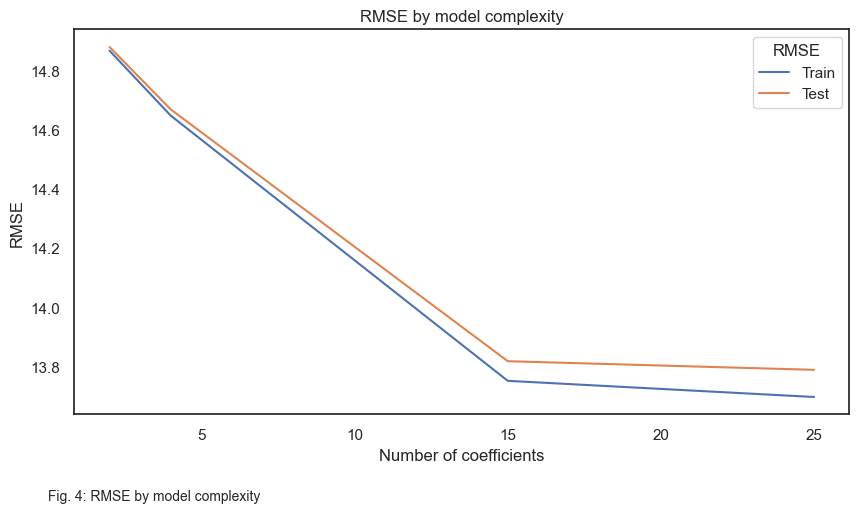

In [12]:
rmse_fig, ax3 = plt.subplots(figsize=(10,5))
rmse_plt = sns.lineplot(
    data = rmse_levels,
    x="nvars", y="value", hue='var')
rmse_plt.set(title='RMSE by model complexity', xlabel="Number of coefficients", ylabel="RMSE")
ax3.legend(title='RMSE')
ax3.text(0, 13.35, 'Fig. 4: RMSE by model complexity', size=10)
rmse_fig.show()

So far, it seems that model 4 has the best performance with the lowest RMSE and cross-validated RMSE: 13.707 and 13.697 respectively. However, the previous model's performances are closely behind since the differences in the RMSE between each model are not great. On the other hand, from Fig. 4, the cross-validated RMSE difference between the train and test split of each model grows. While including more predictors can improve prediction accuracy, the more complex models might experience overfitting, especially with model 4. Looking at Fig. 3's BIC, it is decreasing from model 1 to model 3, then increasing between model 3 and 4. It seems like model 4 is indeed experiencing some overfitting. Hence, while having a slightly larger RMSE than model 4, model 3 has less complexity and is preferred to be the better model to mitigate overfitting.

-----

### 4. Limitation
The models in this paper have some noticeable limitations worth mentioning. Firstly, the models assume that the mean value of hourly wages is the typical value, although this is in fact not the case from Fig. 1. Secondly, models 1 through 4 do not consider any interaction between the predictors, which might present in the dataset. Finally, the models are built with related predictors grouped together via intuition, which might include some unimportant predictors that unnecessarily complicate the models. With all of these limitations, the models might suffer losses in prediction accuracy and generalization performance.

-----
<p style="page-break-after:always;"></p>

## <center>Appendices</center>

### <center>Appendix A</center>
**<center>Full regression table of all models</center>**

In [13]:
# create the regression models
reg1 = smf.ols(formula=reg_formulas[0], data=cleaned_df).fit(cov_type="HC1")
reg2 = smf.ols(formula=reg_formulas[1], data=cleaned_df).fit(cov_type="HC1")
reg3 = smf.ols(formula=reg_formulas[2], data=cleaned_df).fit(cov_type="HC1")
reg4 = smf.ols(formula=reg_formulas[3], data=cleaned_df).fit(cov_type="HC1")

# create the regression table
reg_list = [reg1, reg2, reg3, reg4]
bic = [round(x.bic, 2) for x in reg_list]
rmse_all = [round(rmse(cleaned_df[reg_formulas[x].split("~")[0]], reg_list[x].predict()), 3) for x in range(len(reg_list))]
rmse_kfold = (cv_summary.loc['Average']).tolist()
sg = stargazer.Stargazer(reg_list)
sg.add_line('BIC', bic, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('RMSE', rmse_all, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg.add_line('CV RMSE', rmse_kfold, location=stargazer.LineLocation.FOOTER_BOTTOM)
sg

<p style="page-break-after:always;"></p>

### <center>Appendix B</center>
**<center>80% Prediction Confidence of all models</center>**

In [14]:
# get a sample for test prediction
test = cleaned_df.iloc[200].to_frame().T
test = test.infer_objects()

# building the PI table for all models
alpha = 0.2
pi_list = []

for reg in reg_list:
    pi_list.append(reg.get_prediction(test).summary_frame(alpha=alpha))

pd.DataFrame(
    {
        " ": ["Predicted", "PI_low(80%)", "PI_high(80%)"],
        "Model1": pi_list[0][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model2": pi_list[1][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model3": pi_list[2][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
        "Model4": pi_list[3][["mean", "obs_ci_lower", "obs_ci_upper"]].values.tolist()[0],
    }
).set_index(" ")

,Model1,Model2,Model3,Model4
,,,,
Predicted,29.450556,26.447708,29.429267,28.715455
PI_low(80%),10.387172,7.646103,11.706046,10.929622
PI_high(80%),48.513939,45.249313,47.152489,46.501288
